In [46]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split


In [49]:
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/Tiles_1.0_256_64_11'
tile_size1 = (256,256)
tile_size2 = (256,256,1)
input_shape = (256,256,3)
tile_type = 'Tiles_0.6_256_0_of'

 
x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))

    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.02, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)


In [50]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 20588 samples
Validation set: 2288 samples
Test set: 467 samples


In [59]:
# List to store the paths of images with unique classes
unique_image_paths = []

# Set to store the unique classes that have been encountered
unique_classes_encountered = set()

for i in range(len(Y_train)):
    lbl_arr_path = Y_train[i]

    # Check if the image contains at least one unique class from 1 to 12
    unique_classes = np.unique(np.array(Image.open(lbl_arr_path)))
    unique_classes_1_to_12 = [cls for cls in unique_classes if 1 <= cls <= 12]

    for cls in unique_classes_1_to_12:
        if cls not in unique_classes_encountered:
            # Append the path to the unique_image_paths list
            unique_image_paths.append(lbl_arr_path)

            # Add the unique class to the set of encountered classes
            unique_classes_encountered.add(cls)
            break

# Print the list of paths for images with unique classes

image_paths = []

for mask_path in unique_image_paths:
    # Remove the '-labelled' from the mask path
    image_path = mask_path.replace('-labelled', '')
    image_paths.append(image_path)



In [63]:
# Print the corresponding image paths
np.shape(image_paths),np.shape(unique_image_paths)

((10,), (10,))

In [74]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = class_names = [
            'background',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Bindegewebe',
            'X2 Stroma',
            'Fettgewebe',
            'Muskel',
            'Nerv']
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(0, 11, 1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            img_arr = img_arr.resize(tile_size1)
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize(tile_size1)
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 11), dtype=np.float32)

            for i, value in enumerate(self.unique):
                channels[:, :, i] = (lbl_arr == value).astype(np.uint8) * 255

            lbl_arr = channels
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, 12, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(0, 11):
                axs[i+1].imshow(y_mask[:, :, i])
                axs[i+1].axis('off')  # Remove axes
                axs[i+1].set_title(f'{self.class_names[i]}')
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')


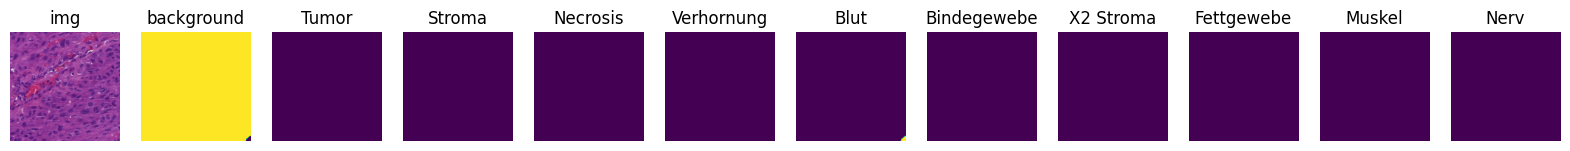

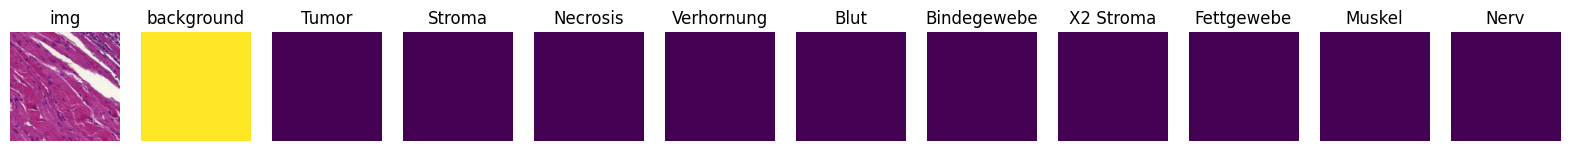

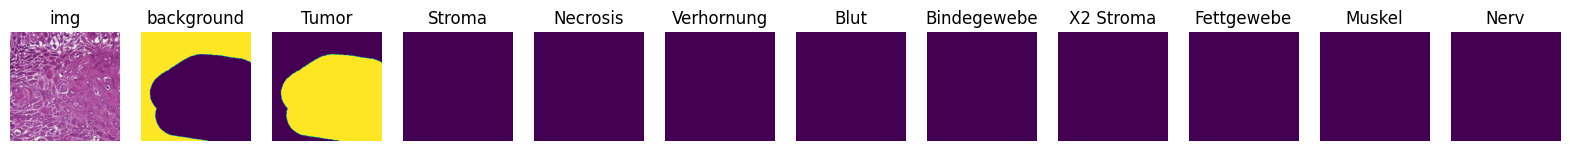

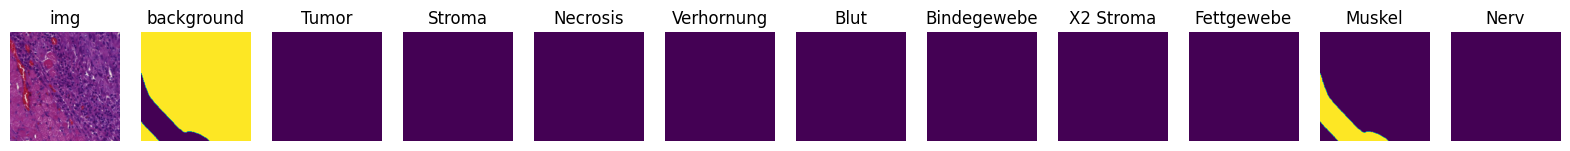

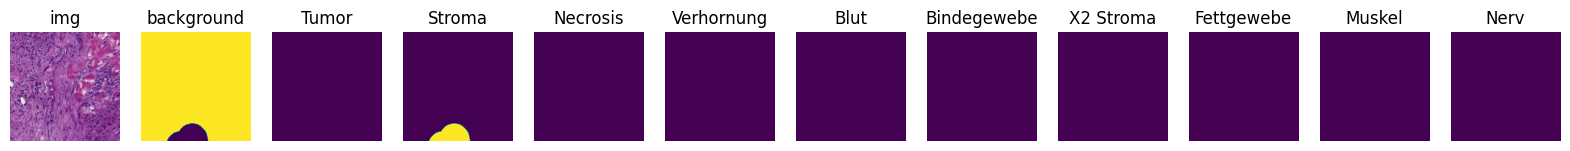

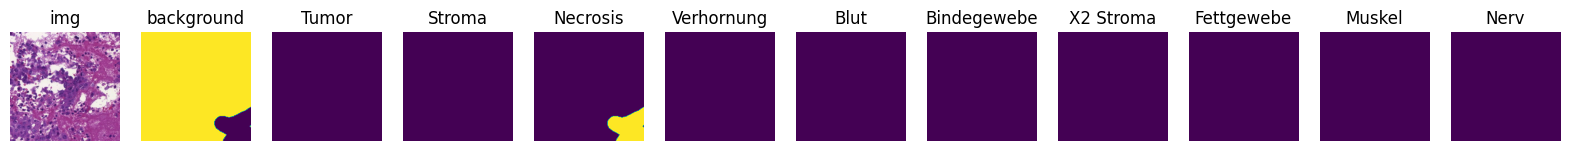

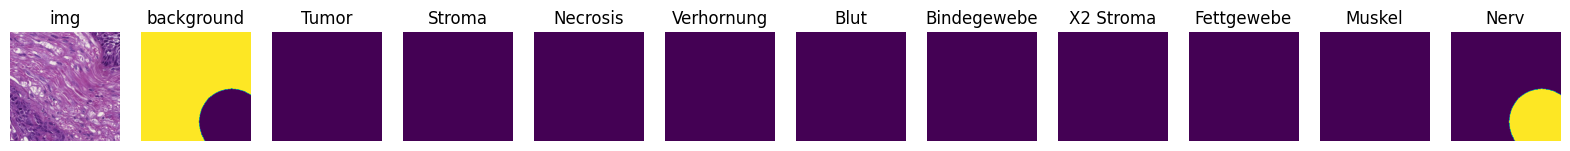

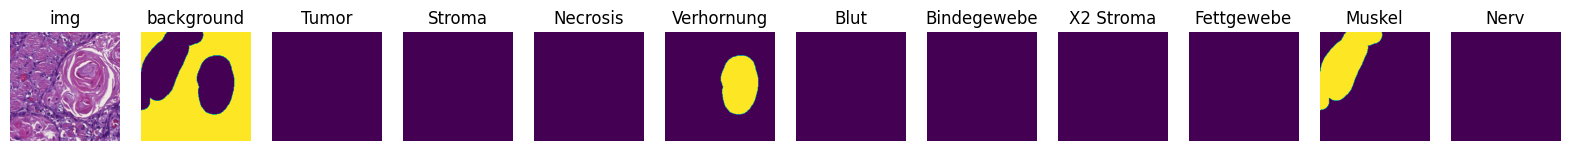

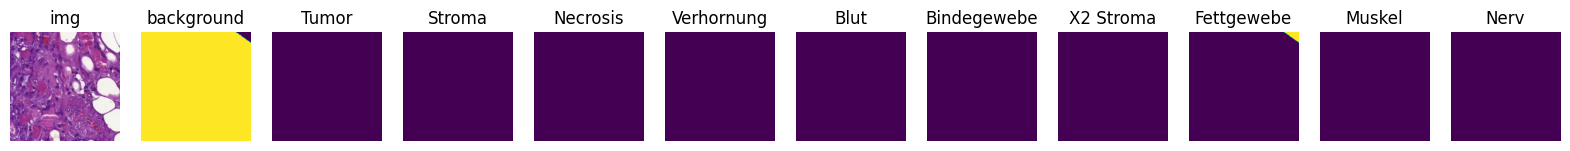

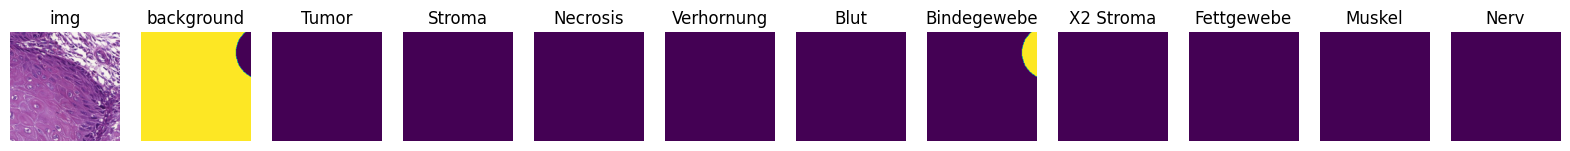

Batch shape (10, 256, 256, 3) and for masks (10, 256, 256, 11)
image shape (256, 256, 3) and for masks (256, 256, 11)
max value for images is 1.0 and for masks 1.0
min value for images is 0.027450980618596077 and for masks 0.0
number of unique values in images is 248 and for masks [0. 1.]


(10, 256, 256, 3)

In [75]:
test = DataGenerator(image_paths,unique_image_paths,batch_size=10,aug=0)
a,b = test.__getitem__(0)
test.viz(a,b)
np.shape(a)

In [88]:
from tensorflow.keras.layers import Add

fil = 32
inputs = Input(input_shape)

# Contractive
conv1 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv2 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv2 = BatchNormalization()(conv2)
skip1 = Add()([conv1, conv2])
pool1 = MaxPooling2D(pool_size=(2, 2))(skip1)

conv3 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv4 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv4 = BatchNormalization()(conv4)
skip2 = Add()([conv3, conv4])
pool2 = MaxPooling2D(pool_size=(2, 2))(skip2)

conv5 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv6 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv6 = BatchNormalization()(conv6)
skip3 = Add()([conv5, conv6])
pool3 = MaxPooling2D(pool_size=(2, 2))(skip3)

conv7 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv8 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv8 = BatchNormalization()(conv8)
skip4 = Add()([conv7, conv8])
pool4 = MaxPooling2D(pool_size=(2, 2))(skip4)

conv9 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv10 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = BatchNormalization()(conv10)
skip5 = Add()([conv9, conv10])


# Expansive
upconv1 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(skip5)
up6 = UpSampling2D(size=(2, 2))(upconv1)
merge6 = concatenate([skip4, up6], axis=3)
conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = UpSampling2D(size=(2, 2))(upconv2)
merge7 = concatenate([skip3, up7], axis=3)
conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(fil * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
up8 = UpSampling2D(size=(2, 2))(upconv3)
merge8 = concatenate([skip2, up8], axis=3)
conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upconv4 = Conv2D(fil * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
up9 = UpSampling2D(size=(2, 2))(upconv4)
merge9 = concatenate([skip1, up9], axis=3)
conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(11, 1, activation='softmax')(conv9)

model = Model(inputs=inputs, outputs=conv10)


In [77]:
from typing import Callable, Union
from tensorflow.keras import backend as K

def multiclass_weighted_squared_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor],
                                                                                                   tf.Tensor]:
    """
    Weighted squared Dice loss.

    Used as loss function for multi-class image segmentation with one-hot encoded masks.

    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted squared Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted squared Dice loss.

        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted squared Dice loss (tf.Tensor, shape=(None,))
        """
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true**2 + y_pred**2) * class_weights  # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

def multiclass_focal_loss(class_weights: Union[list, np.ndarray, tf.Tensor],
                          gamma: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Focal loss.

        FL(p, p̂) = -∑class_weights*(1-p̂)ᵞ*p*log(p̂)

    Used as loss function for multi-class image segmentation with one-hot encoded masks.

    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :param gamma: Focusing parameters, γ_i ≥ 0 (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Focal loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    if not isinstance(gamma, tf.Tensor):
        gamma = tf.constant(gamma)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute focal loss.

        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Focal loss (tf.Tensor, shape=(None,))
        """
        f_loss = -(class_weights * (1-y_pred)**gamma * y_true * K.log(y_pred))

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(f_loss))
        f_loss = K.mean(f_loss, axis=axis_to_reduce)

        return f_loss

    return loss

In [84]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()

def custom_Diceloss(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return loss(y_true_exclude_first, y_pred_exclude_first)

DiceLoss = DiceLoss()
IOUscore0 = IOUScore(class_indexes=0, name='BG')
IOUscore1 = IOUScore(class_indexes=1, name='IOU_Tumor')
IOUscore2 = IOUScore(class_indexes=2, name='IOU_Stroma')
IOUscore3 = IOUScore(class_indexes=3, name='IOU_Necrosis')
IOUscore4 = IOUScore(class_indexes=4, name='IOU_Verhornung')
IOUscore5 = IOUScore(class_indexes=5, name='IOU_Blut')
IOUscore6 = IOUScore(class_indexes=6, name='IOU_Lockeres_Bindegewebe')
IOUscore7 = IOUScore(class_indexes=7, name='IOU_Zellreiches_Stroma')
IOUscore8 = IOUScore(class_indexes=8, name='IOU_Fettgewebe')
IOUscore9 = IOUScore(class_indexes=9, name='IOU_Muskel')
IOUscore10 = IOUScore(class_indexes=10, name='IOU_Nerv')


In [89]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

class_weights = [0.,
                0.27717242,
                0.23668572,
                0.08472734,
                0.07929245,
                0.05276407,
                0.03876243,
                0.16003498,
                0.0090356,
                0.05961123,
                0.01454854]
gamma_value = 2.0
gamma = [gamma_value] * 11


# Define the learning rate scheduler function
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10)

# Update the loss in model compilation
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False),
              loss=loss, 
              metrics=[
                  IOUscore0,
                  IOUscore1,
                  IOUscore2,
                  IOUscore3,
                  IOUscore4,
                  IOUscore5,
                  IOUscore6,
                  IOUscore7,
                  IOUscore8,
                  IOUscore9,
                  IOUscore10,
              ])

history = model.fit(a,b,
                    epochs=200,
                    callbacks=[reduce_lr]
                    )


Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.9646 - BG: 0.0860 - IOU_Tumor: 0.0426 - IOU_Stroma: 0.0039 - IOU_Necrosis: 0.0070 - IOU_Verhornung: 0.0140 - IOU_Blut: 1.6531e-04 - IOU_Lockeres_Bindegewebe: 0.0029 - IOU_Zellreiches_Stroma: 5.8114e-05 - IOU_Fettgewebe: 6.4981e-05 - IOU_Muskel: 0.0282 - IOU_Nerv: 0.0200 - lr: 0.1000
Epoch 2/200
1/1 [==============================] - 0s 111ms/step - loss: 0.9637 - BG: 0.0870 - IOU_Tumor: 0.0439 - IOU_Stroma: 0.0041 - IOU_Necrosis: 0.0071 - IOU_Verhornung: 0.0145 - IOU_Blut: 1.5928e-04 - IOU_Lockeres_Bindegewebe: 0.0030 - IOU_Zellreiches_Stroma: 6.1191e-05 - IOU_Fettgewebe: 7.4995e-05 - IOU_Muskel: 0.0296 - IOU_Nerv: 0.0204 - lr: 0.1000
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 0.9624 - BG: 0.0883 - IOU_Tumor: 0.0459 - IOU_Stroma: 0.0041 - IOU_Necrosis: 0.0075 - IOU_Verhornung: 0.0150 - IOU_Blut: 1.5093e-04 - IOU_Lockeres_Bindegewebe: 0.0031 - IOU_Zellreiches_Stroma: 6.8259e-05 - IOU_Fe

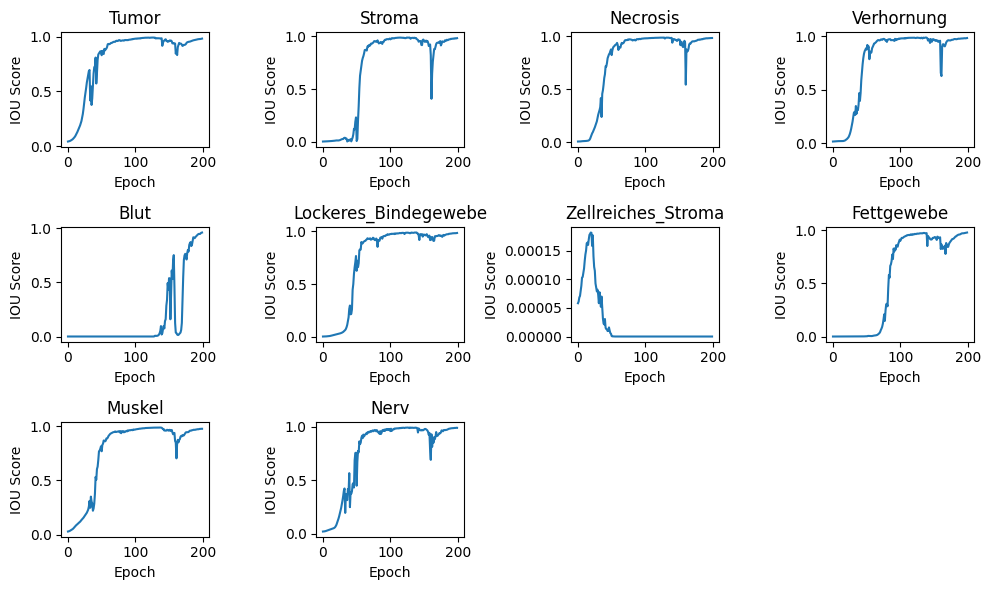

In [93]:
#how was the network on each epoch?

class_names = [
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Nerv']

fig, axes = plt.subplots(3, 4, figsize=(10, 6))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    metric_name = 'IOU_' + class_name
    val_name = 'val_IOU_' + class_name
    axes[i].plot(history.history[metric_name])
    #axes[i].plot(history.history[val_name],alpha=0.4)
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('IOU Score')

# Hide unused subplots
for j in range(len(class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('./attempts/32SGDM_1.0.png') 

plt.show()

In [71]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=True)
a, b =DataGen.__getitem__(0)
score = model.evaluate(a,b)


2/2 [==============================] - 0s 90ms/step - loss: 0.5489 - BG: 0.5847 - IOU_Tumor: 0.5415 - IOU_Stroma: 2.0696e-07 - IOU_Necrosis: 0.5890 - IOU_Verhornung: 0.5000 - IOU_Blut: 0.2817 - IOU_Lockeres_Bindegewebe: 0.5298 - IOU_Zellreiches_Stroma: 7.4979e-10 - IOU_Fettgewebe: 0.0942 - IOU_Muskel: 1.0000 - IOU_Cauter: 8.9354e-12 - IOU_Muskel_längss: 0.5000 - IOU_Nerv: 1.0000


In [90]:
class_names = [
            'BG',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längss',
            'Nerv']

1/1 [==============================] - 0s 311ms/step
(1, 256, 256, 11)


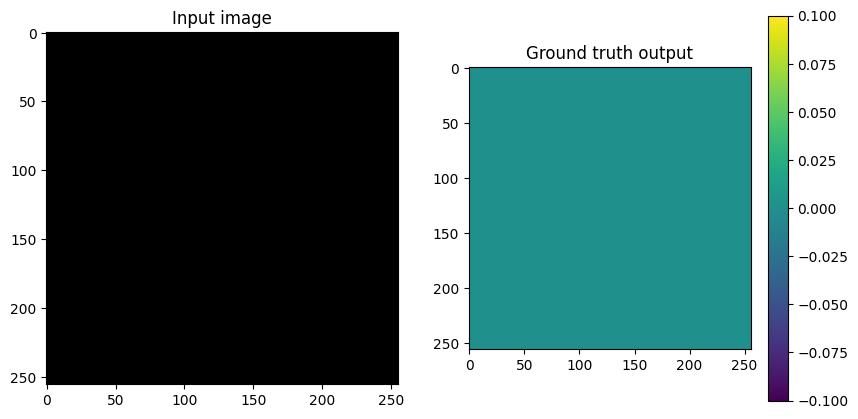

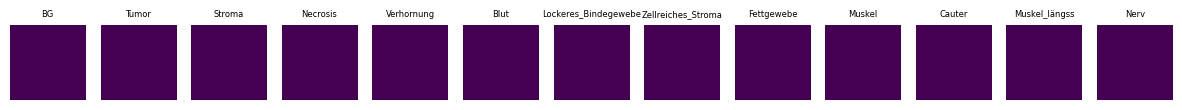

IndexError: index 11 is out of bounds for axis 2 with size 11

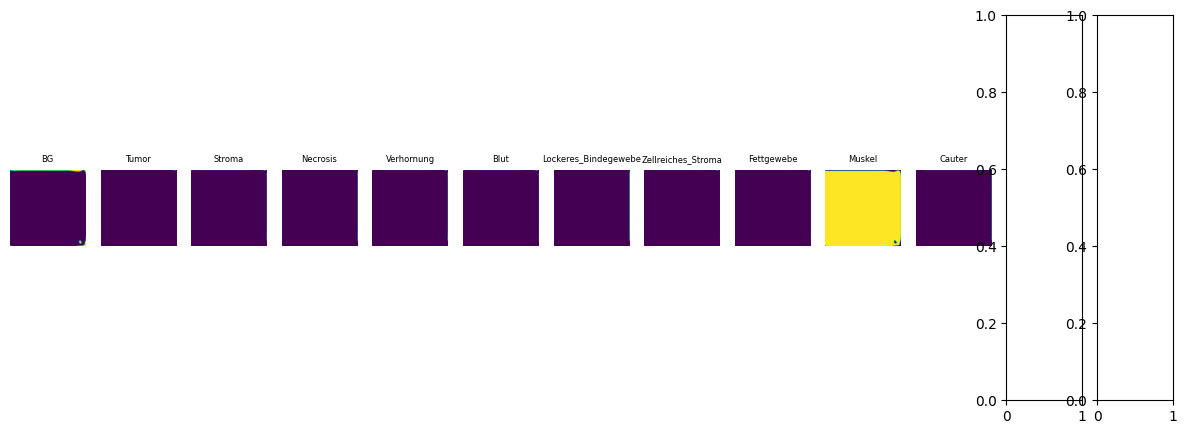

In [91]:
# Normal
DataGen = DataGenerator(X_test, Y_test, batch_size=1, aug=False)
#img, mask = DataGen.__getitem__(3)
img = np.zeros((1,256, 256, 3))
mask = np.zeros((1, 256, 256, 13))
y_pred = model.predict(img)



print(np.shape(y_pred))

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(img[0])
axs[0].set_title('Input image')

# Create an empty array to store the changed image
changed_img = np.zeros((13, 256, 256, 1), dtype=np.uint8)

# Iterate over the channels and assign values accordingly
for i in range(13):
    temp = (mask[:, :, :, i] > 0.).astype(np.uint8)
    changed_img[:, :, :, 0] += temp * (i + 1)


# Plot the ground truth output in the second subplot
im = axs[1].imshow(changed_img[0])
axs[1].set_title('Ground truth output')
plt.colorbar(im, ax=axs[1])

##################################

# Create the subplots
fig, axs = plt.subplots(1, 13, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(mask[0][:, :, i])
    ax.axis('off')
    ax.set_title(f'{class_names[i]}', fontsize=6)

plt.show()

###########################################

# Create the subplots
fig, axs = plt.subplots(1, 13, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(y_pred[0][:, :, i])
    ax.axis('off')
    ax.set_title(f'{class_names[i]}', fontsize=6)

plt.show()


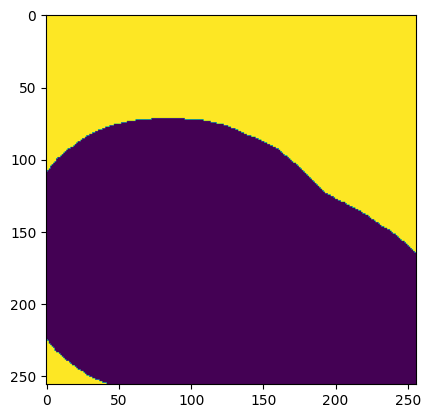

In [44]:
plt.imshow(mask[0,:,:,0])
